# Create embedding for first experiment cranial

In [ ]:
import scanpy as sc
import numpy as np
import scanpy.external as sce
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys
import symphonypy as sp

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/placodes/data"

# Additional functions
exec(open(f"/code/tools/clonal_tools.py").read())
sns.set_style("ticks")

g2m_genes = list(pd.read_csv(f"{DATA_PATH}/cell_cycle_genes/G2M_phase.txt", names=["gene"]).gene) 
g2m_genes = [gene[0].upper() + gene[1:].lower() for gene in g2m_genes]

s_genes = list(pd.read_csv(f"{DATA_PATH}/cell_cycle_genes/S_phase.txt", names=["gene"]).gene) 
s_genes = [gene[0].upper() + gene[1:].lower() for gene in s_genes]

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: 

In [2]:
reference_injections = [
    "injection32",
]

adata = []
for injection in reference_injections:
    adata.append(sc.read_h5ad(f"{DATA_PATH}/anndatas_counts/{injection}.h5ad"))
adata = adata[0].concatenate(adata[1:], join="outer", batch_key=None, fill_value=0, index_unique=None)
adata.obs["E8.5:clones"] = adata.obs["E8.5:clones"].fillna("NA")
adata.var = adata.var[["gene_ids", "mt"]]
adata.var.columns = ["gene_ids", "mt"]
adata = adata[:, ~np.isin(adata.var_names, ["GFPbc", "TOMbc"])]
adata.layers["counts"] = adata.X.copy()
adata.var.mt = adata.var.mt.astype(bool)

adata.write_h5ad(f"{DATA_PATH}/anndatas_counts/reference_E11_cranial.h5ad")

/tmp/ipykernel_19077/2322007941.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata[0].concatenate(adata[1:], join="outer", batch_key=None, fill_value=0, index_unique=None)
/tmp/ipykernel_19077/2322007941.py:13: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [3]:
adata = sc.read_h5ad(f"{DATA_PATH}/anndatas_counts/reference_E11_cranial.h5ad")

In [4]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    layer="counts",
    n_top_genes=5000,
)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata.raw = adata

In [5]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=30)

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
sp.pp.harmony_integrate(adata, key="sample_id", max_iter_harmony=30, verbose=True)
sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_pca_harmony")
sc.tl.umap(adata)

2025-02-27 11:04:15,543 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Harmony integration with harmonypy is preforming.


2025-02-27 11:04:17,715 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-27 11:04:17,808 - harmonypy - INFO - Iteration 1 of 30
2025-02-27 11:04:20,935 - harmonypy - INFO - Iteration 2 of 30
2025-02-27 11:04:24,638 - harmonypy - INFO - Iteration 3 of 30
2025-02-27 11:04:27,790 - harmonypy - INFO - Iteration 4 of 30
2025-02-27 11:04:30,185 - harmonypy - INFO - Iteration 5 of 30
2025-02-27 11:04:31,126 - harmonypy - INFO - Converged after 5 iterations
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
for resolution in [0.5, 1, 2]:
    sc.tl.leiden(adata, key_added=f"leiden_{resolution}", resolution=resolution)

/tmp/ipykernel_19077/586634555.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=f"leiden_{resolution}", resolution=resolution)


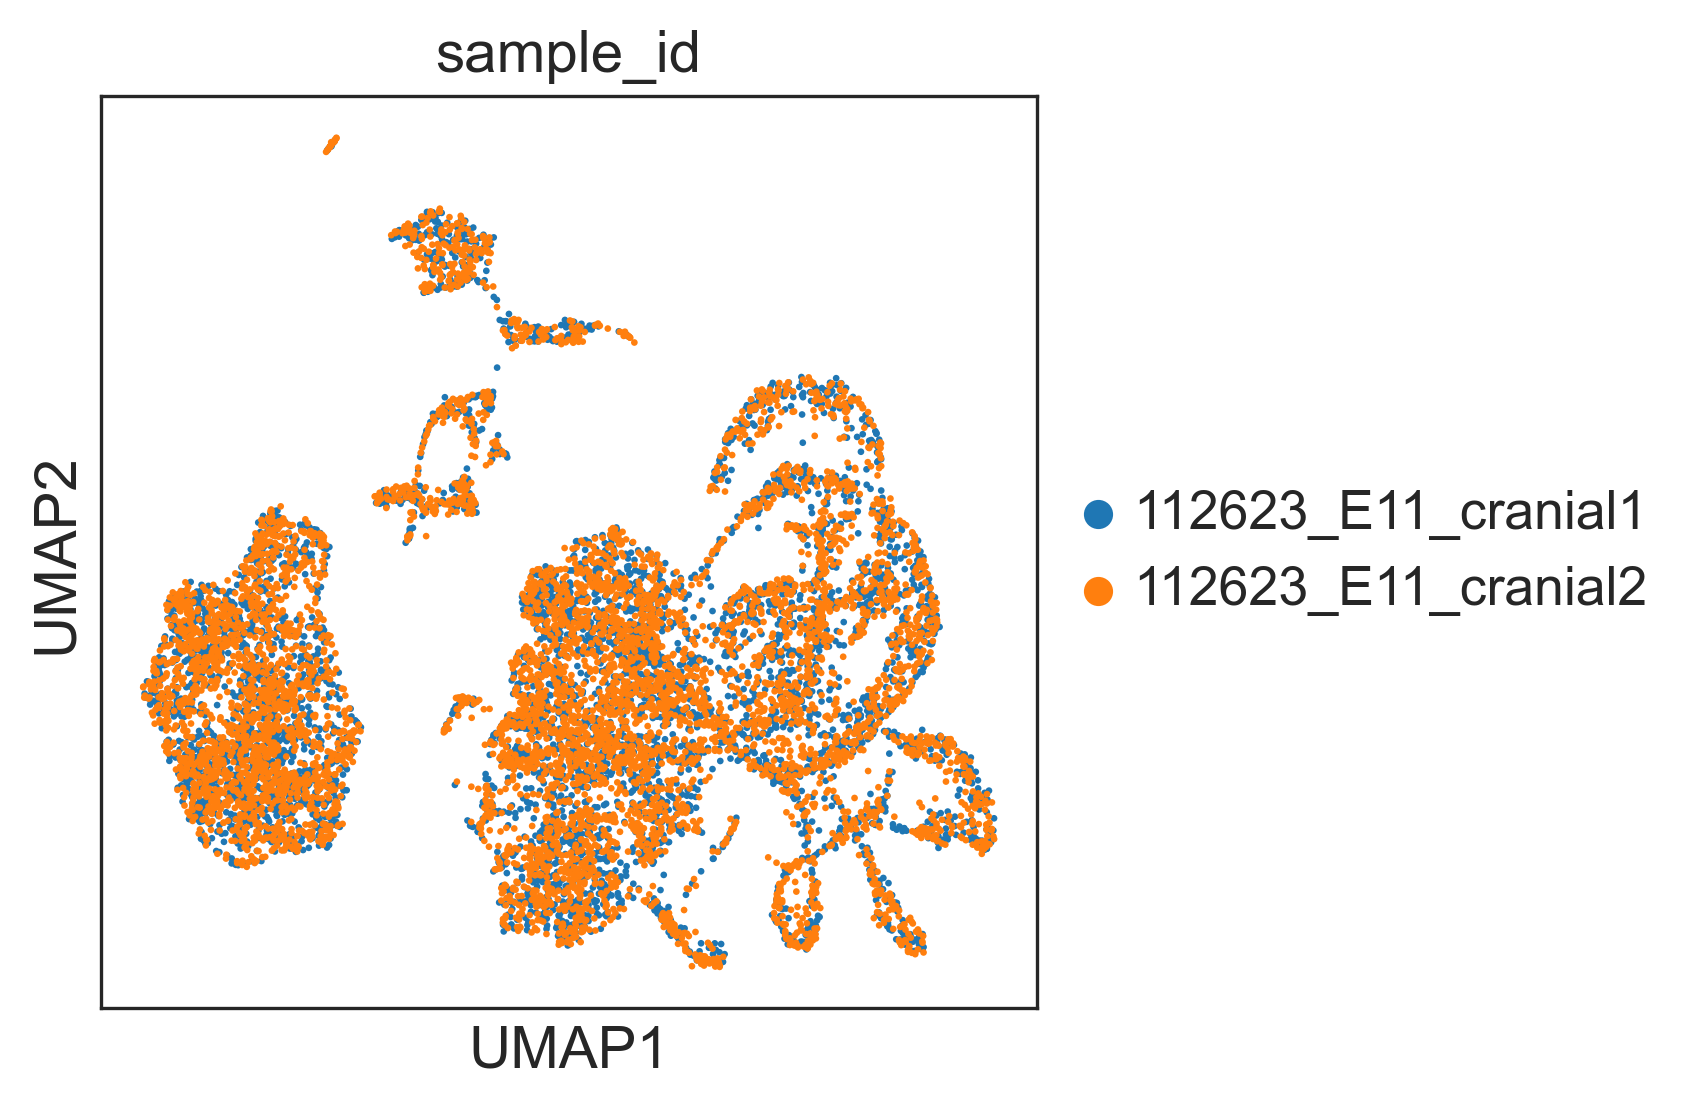

In [8]:
sc.pl.umap(adata, color="sample_id")

In [ ]:
if not os.path.exists(f"{DATA_PATH}/anndatas"):
    os.makedirs(f"{DATA_PATH}/anndatas")

In [9]:
adata.write_h5ad(f"{DATA_PATH}/anndatas/reference_E11_cranial.h5ad")